In [1]:
import os
import re
import pandas as pd
import numpy as np
import scipy
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize, Normalizer, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, explained_variance_score, make_scorer
from sklearn.ensemble import AdaBoostRegressor, IsolationForest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor, LocalOutlierFactor
from sklearn.naive_bayes import ComplementNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPRegressor

Using TensorFlow backend.


In [3]:
#set the visual style
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 5000)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

# Import Data

In [4]:
query_dir = 'queries'

In [5]:
queries = {}
for query_file in (os.listdir(query_dir)):
    with open(os.path.join(query_dir, query_file), 'r') as query:
        queries[query_file] = query.read()

In [6]:
query_client = bigquery.Client()

In [7]:
request = queries['combined_analysis_data.sql']

In [8]:
data = query_client.query(request).to_dataframe()

In [9]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4716 entries, 0 to 5321
Data columns (total 22 columns):
ad_id                 4716 non-null int64
apt_id                3432 non-null object
new_building          4716 non-null bool
num_bedrooms          4645 non-null float64
floor                 3938 non-null float64
primary_size          4716 non-null float64
total_size            4608 non-null float64
price                 4716 non-null float64
property_type         4716 non-null object
ownership_type        4716 non-null object
construction_year     4711 non-null float64
energy_character      1657 non-null object
common_expenses       967 non-null float64
brokerage_expenses    1281 non-null float64
common_wealth         678 non-null float64
common_debt           1211 non-null float64
time_s                4566 non-null float64
lat                   4566 non-null float64
lng                   4566 non-null float64
address               4716 non-null object
short_description     471

In [11]:
request = queries['all_post_code_places.sql']

In [12]:
post_code_data = query_client.query(request).to_dataframe()

In [13]:
post_code_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117498 entries, 0 to 117497
Data columns (total 6 columns):
post_code          117498 non-null object
radius             117498 non-null int64
place_name         117498 non-null object
place_type         117498 non-null object
place_attribute    117498 non-null object
attribute_value    42240 non-null float64
dtypes: float64(1), int64(1), object(4)
memory usage: 5.4+ MB


# Feature Engineering
## Energy Letter and Color

In [14]:
energy_cols = ['energy_letter', 'energy_color']

for col in energy_cols:
    data[col] = 0

energy_res = [[c.strip() for c in char.split('-')] if char is not None and '-' in char else [None, None] for char in data.energy_character]
data[energy_cols] = pd.DataFrame(energy_res, columns=energy_cols)

## Post Codes

In [15]:
def get_postcode_from_address(address):
    try:
        return re.search(r'(.*)(\d{4})(.*)', address, re.I)[2]
    except:
        return None

In [16]:
data['post_code'] = data.address.apply(get_postcode_from_address)

## Settlement Names

In [17]:
post_codes_no = pd.read_csv('post_codes_no.csv', dtype={'post_code': str}).set_index('post_code')

In [18]:
post_codes_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5057 entries, 0001 to 9991
Data columns (total 4 columns):
name               5057 non-null object
municipality_id    5057 non-null int64
municipality       5057 non-null object
type               5057 non-null object
dtypes: int64(1), object(3)
memory usage: 197.5+ KB


In [19]:
data['settlement_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_no, how='left', left_on='post_code', right_index=True)['municipality']

## Oslo Neighborhood Names

In [20]:
post_codes_osl = pd.read_csv('post_codes.csv', dtype={'post_code':str}).set_index('post_code', drop=True)

In [21]:
post_codes_osl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 995 entries, 0001 to 2185
Data columns (total 5 columns):
lat                  995 non-null float64
lng                  995 non-null float64
municipality         995 non-null object
neighborhood_name    940 non-null object
population           590 non-null float64
dtypes: float64(3), object(2)
memory usage: 46.6+ KB


In [22]:
data['neighborhood_name'] = pd.merge(data[['ad_id', 'post_code']], post_codes_osl, how='left', left_on='post_code', right_index=True)['neighborhood_name']

## Combine Oslo Neighborhood Names and Settlement Names

In [23]:
data['area_name'] = [s_n.lower() if s_n != 'OSLO' else n_n.lower() for s_n, n_n in zip(data['settlement_name'], data['neighborhood_name'])]

In [24]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: True if s_n == 'OSLO' else False)

## Price Per Square Meter

In [25]:
data['price_per_sq_m'] = data.price.div(data.primary_size).round(0)

In [26]:
new_building_pct = pd.Series(data[data.new_building == True]\
                             .groupby('area_name')['ad_id'].count()\
                             .div(data\
                                  .groupby('area_name')['ad_id'].count()),
                             name='area_new_building_pct')

data = data.merge(new_building_pct, how='left', left_on='area_name', right_index=True)

In [27]:
data['exclusive'] = data.short_description.str.lower().str.contains(r'sydvestvend|terrasse|utsikt|eksklusiv')
data['renovated'] = data.short_description.str.lower().str.contains(r'oppgraderingsbrev|nyoppusset|opparbeidet')

In [28]:
data['comb_property_type'] = ['house' if pt in ['Enebolig', 'Rekkehus', 'Tomannsbolig']
                              else 'apartment' if pt == 'Leilighet'
                              else 'other'
                              for pt in data['property_type']]

In [29]:
median_property_prices = pd.pivot_table(data=data[data.comb_property_type.isin(['house', 'apartment'])],
                                        index='post_code',
                                        columns='comb_property_type',
                                        values='price_per_sq_m',
                                        aggfunc='median')

median_property_prices.rename(columns={'apartment': 'med_price_apartment', 'house': 'med_price_house'}, inplace=True)

data = data.merge(median_property_prices, how='left', left_on='post_code', right_index=True)

# Data Imputation

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4716 entries, 0 to 5321
Data columns (total 36 columns):
ad_id                    4716 non-null int64
apt_id                   3432 non-null object
new_building             4716 non-null bool
num_bedrooms             4645 non-null float64
floor                    3938 non-null float64
primary_size             4716 non-null float64
total_size               4608 non-null float64
price                    4716 non-null float64
property_type            4716 non-null object
ownership_type           4716 non-null object
construction_year        4711 non-null float64
energy_character         1657 non-null object
common_expenses          967 non-null float64
brokerage_expenses       1281 non-null float64
common_wealth            678 non-null float64
common_debt              1211 non-null float64
time_s                   4566 non-null float64
lat                      4566 non-null float64
lng                      4566 non-null float64
address    

## Impute Number Of Bedrooms

In [31]:
data['primary_size_bin'] = pd.cut(data['primary_size'], bins=[-np.inf, 30, 40, 50, 60, 70, 80, 100, 150, 200, np.inf])

In [32]:
num_bedrooms_grouping = data.groupby(['primary_size_bin'])['num_bedrooms'].median()

In [33]:
data['num_bedrooms'] = [num_bedrooms_grouping.loc[size_bin] if np.isnan(num_bedr) else num_bedr
                        for size_bin, num_bedr
                        in zip(data['primary_size_bin'], data['num_bedrooms'])]

## Impute Floor

In [34]:
data['floor_level'] = [fl if prop_type == 'Leilighet' else 1 for fl, prop_type in zip(data['floor'], data['property_type'])]
data['num_floors'] = [fl if prop_type != 'Leilighet' else 1 for fl, prop_type in zip(data['floor'], data['property_type'])]

data['floor_level'] = data['floor_level'].fillna(1)
data['num_floors'] = data['num_floors'].fillna(1)
data['floor'] = data['floor'].fillna(2)

## Impute Total Size

In [35]:
data['total_size'] = [primary_size if np.isnan(total_size) else total_size
                      for primary_size, total_size
                      in zip(data['primary_size'], data['total_size'])]

## Impute Construction Year

In [36]:
data['construction_year'].fillna(data[data['new_building'] == False]['construction_year'].median(), inplace=True) 

## Impute Energy Character

In [37]:
constr_year_bins = [-np.inf, 1900, 1945, 1965, 1970, 1980, 1990, 2000, 2010, np.inf]
data['construction_year_bin'] = pd.cut(data['construction_year'],
                                       bins=constr_year_bins)

In [38]:
to_plot = data.groupby(['construction_year_bin', 'energy_letter'])['energy_letter'].count()

In [39]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [40]:
energy_letter_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [41]:
def imnpute_energy_letter(letter, construction_year_bin):
    if str(letter) in 'ABCDEFG':
        return letter
    else:
        return energy_letter_grouping.loc[construction_year_bin]

In [42]:
data['energy_letter'] = [imnpute_energy_letter(letter, construction_year_bin) for letter, construction_year_bin in zip(data['energy_letter'], data['construction_year_bin'])]

In [43]:
to_plot = data.groupby(['construction_year_bin', 'energy_color'])['energy_color'].count()

In [44]:
most_common_energy_c = []
constr_year_index = []
for y in to_plot.index.get_level_values('construction_year_bin').unique():
    most_common_energy_c.append(to_plot.loc[y].sort_values(ascending=False).index[0])
    constr_year_index.append(y)

In [45]:
energy_color_grouping = pd.Series(most_common_energy_c, index=constr_year_index)

In [46]:
def imnpute_energy_color(color, construction_year_bin):
    if str(color) in ['mørkegrønn', 'oransje', 'lysegrønn', 'rød', 'gul']:
        return color
    else:
        return energy_color_grouping.loc[construction_year_bin]

In [47]:
data['energy_color'] = [imnpute_energy_color(color, construction_year_bin) for color, construction_year_bin in zip(data['energy_color'], data['construction_year_bin'])]

## Impute Travel Time

In [48]:
missing_transport_factor = 1
data['time_s'].fillna(data['time_s'].max() * missing_transport_factor, inplace=True)

# Google Maps Data

In [49]:
post_code_data.head()

,post_code,radius,place_name,place_type,place_attribute,attribute_value
0,0001,500,Oslo,locality,rating,NaN
1,0001,500,Oslo,political,rating,NaN
2,0001,500,Oslo Opera House,premise,rating,NaN
3,0001,500,Oslo Opera House,point_of_interest,rating,NaN
4,0001,500,Oslo Opera House,establishment,rating,NaN


In [50]:
neighborhood_data = pd.DataFrame(index=post_code_data.post_code.unique())

In [51]:
neighborhood_data['mean_post_code_rating'] = post_code_data[(post_code_data.place_attribute == 'rating')]\
                                             .groupby('place_name').first()\
                                             .groupby('post_code')['attribute_value'].mean()

In [52]:
neighborhood_data['post_code_place_count'] = post_code_data[(post_code_data.place_attribute == 'rating')]\
                                             .groupby('place_name').first()\
                                             .groupby('post_code')['attribute_value'].count()

In [53]:
to_plot = post_code_data[post_code_data.place_attribute == 'rating']
place_counts = pd.pivot_table(data=to_plot, index='post_code', columns='place_type', values='attribute_value', aggfunc='count', fill_value=0)

In [54]:
neighborhood_data = neighborhood_data.join(place_counts)

In [55]:
to_plot = post_code_data[post_code_data.place_attribute == 'rating']
neighborhood_data['establishment_rating'] = pd.pivot_table(data=to_plot,
                                                           index='post_code',
                                                           columns='place_type',
                                                           values='attribute_value',
                                                           aggfunc='mean',
                                                           fill_value=0)['establishment']

In [56]:
to_plot = post_code_data[(post_code_data.place_name.str.lower().str.contains(r'meny'))
                         & (post_code_data.place_type == 'store')
                         & (post_code_data.place_attribute == 'rating')]

neighborhood_data['meny_store'] = pd.pivot_table(data=to_plot,
                                                 index='post_code',
                                                 values='attribute_value',
                                                 aggfunc='count',
                                                 fill_value=0)

In [57]:
to_plot = post_code_data[(post_code_data.place_name.str.lower().str.contains(r'marina|båt|boat'))
                         & (post_code_data.place_type == 'point_of_interest')
                         & (post_code_data.place_attribute == 'rating')]

neighborhood_data['marina'] = pd.pivot_table(data=to_plot,
                                             index='post_code',
                                             values='attribute_value',
                                             aggfunc='count',
                                             fill_value=0)

In [58]:
to_plot = post_code_data[(post_code_data.place_name.str.lower().str.contains(r'sats'))
                         & (post_code_data.place_type == 'gym')
                         & (post_code_data.place_attribute == 'rating')]

neighborhood_data['sats'] = pd.pivot_table(data=to_plot,
                                           index='post_code',
                                           values='attribute_value',
                                           aggfunc='count',
                                           fill_value=0)

In [59]:
neighborhood_data.fillna(0, inplace=True)

In [60]:
data = data.merge(neighborhood_data, how='left', left_on='post_code', right_index=True)

In [61]:
neighborhood_cols = list(neighborhood_data.columns)

# National Health Institute Data

In [62]:
request = queries['full_fhi_data.sql']

In [63]:
fhi_data = query_client.query(request).to_dataframe()

In [64]:
fhi_data.head()

,dataset,area_name,year,value
0,income_inequality,hurdal,2013,0.023
1,income_inequality,st.hanshaugen,2013,0.038
2,income_inequality,frogner,2013,0.045
3,income_inequality,ullern,2013,0.039
4,income_inequality,vestre aker,2013,0.043


In [65]:
fhi_data_latest = pd.DataFrame(index=fhi_data.area_name.unique())
for dataset in fhi_data.dataset.unique():
    to_join = fhi_data[fhi_data.dataset == dataset]
    latest_year = to_join[to_join.value.notna()].year.max()
    to_join_latest_year = to_join[to_join.year == latest_year]
    to_join_pivot = pd.pivot_table(data=to_join_latest_year,
                                   index='area_name',
                                   values='value').rename(columns={'value': dataset})
    fhi_data_latest = fhi_data_latest.join(to_join_pivot)

In [66]:
fhi_data_latest.head()

,income_inequality,uni_graduates,low_income_households,cramped_spaces,immigrant_pct
hurdal,0.025,0.35,0.168,0.128,0.103
st.hanshaugen,0.038,0.73,0.186,0.469,0.278
frogner,0.047,0.72,0.160,0.328,0.280
ullern,0.040,0.76,0.066,0.160,0.199
vestre aker,0.045,0.77,0.069,0.140,0.178


In [67]:
fhi_cols = list(fhi_data_latest.columns)

In [68]:
data = data.merge(fhi_data_latest, how='left', left_on='area_name', right_index=True)

# IRS Data

# Other Data

In [69]:
rich_post_codes = pd.read_csv('high_income_post_codes.csv', dtype={'post_code': str})

In [70]:
rich_post_codes.set_index('post_code', inplace=True)

In [71]:
data = data.merge(rich_post_codes['high_income_post_code'], how='left', left_on='post_code', right_index=True)

In [72]:
data['high_income_post_code'] = data['high_income_post_code'].fillna(False)

# Remove Properties Other Than Houses and Apartments

In [73]:
data = data[~data.property_type.isin(['Garasje/Parkering', 'Gårdsbruk/Småbruk'])].copy()

# Mark Selected Columns

In [74]:
num_cols = ['price_per_sq_m', 'price', 'primary_size', 'time_s', 'floor', 'num_bedrooms',
            'construction_year', 'area_new_building_pct', 'med_price_apartment', 'med_price_house'] + fhi_cols + neighborhood_cols
cat_cols = ['comb_property_type', 'ownership_type', 'address_oslo', 'new_building',
            'high_income_post_code', 'exclusive', 'renovated']
text_cols = ['short_description', 'full_description']

In [75]:
sample_size = 5

In [76]:
data_sample_from_new_buildings = data.groupby('ad_id').apply(lambda obj: obj.sample(sample_size)
                                                             if len(obj) > sample_size
                                                             else obj.sample(len(obj)))

In [77]:
num_data = data_sample_from_new_buildings[num_cols].copy()

In [78]:
cat_data = data_sample_from_new_buildings[cat_cols].copy()

In [79]:
for col in cat_cols:
    cat_data = cat_data.join(pd.get_dummies(cat_data[col], prefix=col, drop_first=True))
    cat_data.drop(col, axis=1, inplace=True)

In [80]:
text_data = data_sample_from_new_buildings[text_cols].copy()

# Predict Price With Numeric And Categorical Features

In [81]:
def get_learning_curves(estimator, X, y, train_sizes=np.arange(0.1, 1.1, 0.1), score='neg_mean_absolute_error', cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=train_sizes, scoring=score, cv=cv)
    curve_data = pd.DataFrame(columns = range(train_scores.shape[1]))
    for result, result_type in zip([train_scores, test_scores], ['train', 'test']):
        frame = pd.DataFrame(result)
        frame['size'] = train_sizes
        frame['type'] = result_type
        curve_data = curve_data.append(frame, ignore_index = True)
    curve_data = curve_data.melt(id_vars = ['size', 'type'], var_name = 'cv_fit', value_name = 'score')
    return curve_data

In [82]:
def get_cv_res(estimator, X, y, score=['neg_mean_absolute_error'], cv=5):
    cross_val = cross_validate(estimator, X, y, scoring=score, cv=cv)
    return cross_val

In [83]:
def print_cv_res(cross_val):
    for key, val in cross_val.items():
        print('Mean {}, {:.2f}'.format(key, val.mean()))

# Define Hyperparameters

In [84]:
metrics = ['neg_mean_absolute_error', 'neg_median_absolute_error', 'r2', 'explained_variance', 'max_error']
cv = 3
random_seed = 42
var_threshold = 0.1
test_size = 0.3
preferred_score = 'r2'
tensorflow.set_random_seed(random_seed)

In [85]:
def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation="relu"))
    model.add(Dense(16, activation="relu"))
    # model.add(Dropout(0.25))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(4, activation="relu"))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [86]:
estimators = {'deep_learning_regressor': KerasRegressor(build_fn=create_model, epochs=700, batch_size=700, verbose=False),
              'adaboost': AdaBoostRegressor(random_state=random_seed),
              'linear': LinearRegression(),
              'kneighbors': KNeighborsRegressor(),
              'bayes': ComplementNB(),
              'mlp': MLPRegressor(random_state=random_seed)}

In [87]:
estimator = estimators['adaboost']

# Define Model Data
## Remove NaNs

In [88]:
model_data = num_data.join(cat_data)

In [89]:
model_data.dropna(inplace=True)

## Select Properties In Oslo

In [90]:
# model_data = model_data[model_data.address_oslo_True == 1].copy()
# model_data.drop('address_oslo_True', axis=1, inplace=True)

In [91]:
model_data.shape

(1238, 133)

## Remove Low Variance Features

In [92]:
var_estimator = VarianceThreshold(threshold=var_threshold)

In [93]:
var_estimator.fit(model_data)

VarianceThreshold(threshold=0.1)

In [94]:
variances = pd.Series(var_estimator.variances_, index=model_data.columns)

In [95]:
variances.sort_values(ascending=False).head(30)

price                       9.824752e+12
price_per_sq_m              4.151232e+08
med_price_apartment         2.987658e+08
med_price_house             2.761547e+08
time_s                      6.762710e+06
primary_size                2.607708e+03
construction_year           5.549200e+02
post_code_place_count       2.574432e+01
point_of_interest           1.894888e+01
establishment               1.894888e+01
store                       8.096534e+00
health                      2.248985e+00
floor                       1.829889e+00
home_goods_store            1.583857e+00
food                        1.437829e+00
num_bedrooms                1.156180e+00
mean_post_code_rating       1.004728e+00
grocery_or_supermarket      7.159601e-01
school                      5.957913e-01
restaurant                  4.969399e-01
furniture_store             4.694711e-01
clothing_store              4.388553e-01
car_repair                  4.344734e-01
electronics_store           4.246524e-01
hair_care       

In [96]:
variance_filtered_features = pd.Series(var_estimator.get_support(), index=model_data.columns)

In [97]:
variance_selected_features = list(variance_filtered_features[variance_filtered_features == True].index)

In [98]:
model_data = model_data[variance_selected_features].copy()

## List All Columns

In [99]:
model_data.columns

Index(['price_per_sq_m', 'price', 'primary_size', 'time_s', 'floor',
       'num_bedrooms', 'construction_year', 'med_price_apartment',
       'med_price_house', 'mean_post_code_rating', 'post_code_place_count',
       'bank', 'cafe', 'car_dealer', 'car_repair', 'clothing_store', 'dentist',
       'doctor', 'electrician', 'electronics_store', 'establishment',
       'finance', 'florist', 'food', 'furniture_store', 'gas_station',
       'general_contractor', 'grocery_or_supermarket', 'gym', 'hair_care',
       'hardware_store', 'health', 'home_goods_store', 'lodging',
       'meal_delivery', 'meal_takeaway', 'pharmacy', 'place_of_worship',
       'plumber', 'point_of_interest', 'post_office', 'real_estate_agency',
       'restaurant', 'school', 'storage', 'store', 'supermarket',
       'transit_station', 'comb_property_type_house', 'ownership_type_Andel',
       'ownership_type_Eier (Selveier)', 'new_building_True',
       'exclusive_True'],
      dtype='object')

## Remove Outliers

In [100]:
outlier_detector = LocalOutlierFactor()

In [101]:
outlier_detector.fit(model_data)

/Users/ruslan.kozhuharov/venvs/home_oslo_home/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=False, p=2)

In [102]:
model_data['neg_outlier_factor'] = outlier_detector.negative_outlier_factor_

In [103]:
model_data = model_data[model_data.neg_outlier_factor > -1.5].copy()

In [104]:
model_data.drop('neg_outlier_factor', axis=1, inplace=True)

## Select Modelling Target

In [105]:
target = 'price_per_sq_m'
possible_targets = ['price_per_sq_m', 'price']
possible_targets.remove(target)

In [106]:
model_data.drop(possible_targets, axis=1, inplace=True)

In [107]:
cols = list(model_data.columns)
cols.remove(target)
cols.append(target)
model_data = model_data[cols]

## Define X and y

In [108]:
X = model_data.drop(target, axis=1)
y = model_data[target]

In [109]:
X.shape

(1204, 51)

In [110]:
x_cols = X.columns

## Perform Train-Test Split

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=test_size,
                                                    random_state=random_seed)

In [112]:
X_train.shape

(842, 51)

In [113]:
X_sparse = scipy.sparse.csr_matrix(X.values)

## Define Pipeline

In [114]:
steps = []

# steps.append(('scale', MaxAbsScaler()))
steps.append(('scale', MinMaxScaler()))
steps.append(('normalize', Normalizer()))
# steps.append(('pca', PCA(n_components=10)))
# steps.append(('standardize', StandardScaler()))
steps.append(('estimator', estimator))

In [115]:
pipeline = Pipeline(steps)

# Perform Recursive Feature Elimination

In [116]:
rfe = RFECV(estimator, step=1, cv=KFold(cv), scoring='neg_median_absolute_error')

In [117]:
rfe.fit(X_train, y_train)

RFECV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
      estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                  loss='linear', n_estimators=50,
                                  random_state=42),
      min_features_to_select=1, n_jobs=None,
      scoring='neg_median_absolute_error', step=1, verbose=0)

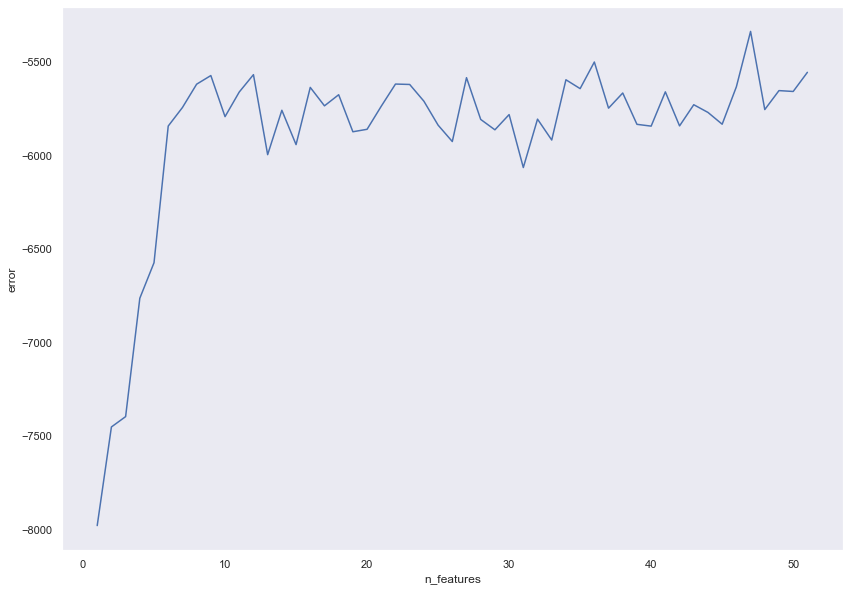

In [118]:
plt.figure()
plt.xlabel('n_features')
plt.ylabel('error')
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

## Select Optimal Features

In [119]:
top_n = 30
# optimal_n_features = min(rfe.grid_scores_.argmax() + 1, top_n)
optimal_n_features = rfe.grid_scores_.argmax() + 1

In [120]:
print(f'The optimal number of features is: {optimal_n_features}')

The optimal number of features is: 47


In [121]:
feature_ranking = pd.Series(rfe.ranking_, index=x_cols)

In [122]:
feature_ranking.sort_values()

primary_size                      1
gym                               1
hair_care                         1
hardware_store                    1
health                            1
lodging                           1
meal_delivery                     1
meal_takeaway                     1
pharmacy                          1
place_of_worship                  1
plumber                           1
point_of_interest                 1
real_estate_agency                1
restaurant                        1
school                            1
storage                           1
store                             1
supermarket                       1
transit_station                   1
comb_property_type_house          1
ownership_type_Andel              1
ownership_type_Eier (Selveier)    1
new_building_True                 1
general_contractor                1
exclusive_True                    1
furniture_store                   1
construction_year                 1
med_price_apartment         

In [123]:
selected_features = list(feature_ranking.sort_values()[:optimal_n_features].index)

In [124]:
selected_features

['primary_size',
 'gym',
 'hair_care',
 'hardware_store',
 'health',
 'lodging',
 'meal_delivery',
 'meal_takeaway',
 'pharmacy',
 'place_of_worship',
 'plumber',
 'point_of_interest',
 'real_estate_agency',
 'restaurant',
 'school',
 'storage',
 'store',
 'supermarket',
 'transit_station',
 'comb_property_type_house',
 'ownership_type_Andel',
 'ownership_type_Eier (Selveier)',
 'new_building_True',
 'general_contractor',
 'exclusive_True',
 'furniture_store',
 'construction_year',
 'med_price_apartment',
 'med_price_house',
 'mean_post_code_rating',
 'post_code_place_count',
 'bank',
 'cafe',
 'gas_station',
 'num_bedrooms',
 'car_repair',
 'dentist',
 'doctor',
 'electrician',
 'electronics_store',
 'time_s',
 'establishment',
 'finance',
 'florist',
 'food',
 'clothing_store',
 'floor']

# Fit Model

In [125]:
pipeline.fit(X_train[selected_features], y_train)

Pipeline(memory=None,
         steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('normalize', Normalizer(copy=True, norm='l2')),
                ('estimator',
                 AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                   loss='linear', n_estimators=50,
                                   random_state=42))],
         verbose=False)

In [126]:
pred = pipeline.predict(X_test[selected_features])

In [127]:
y_pred = pd.Series(pred, index=y_test.index, name='predicted')

# Draw Learning Curves

In [128]:
learning_curve_res = get_learning_curves(pipeline, X_train[selected_features], y_train, score='neg_median_absolute_error')

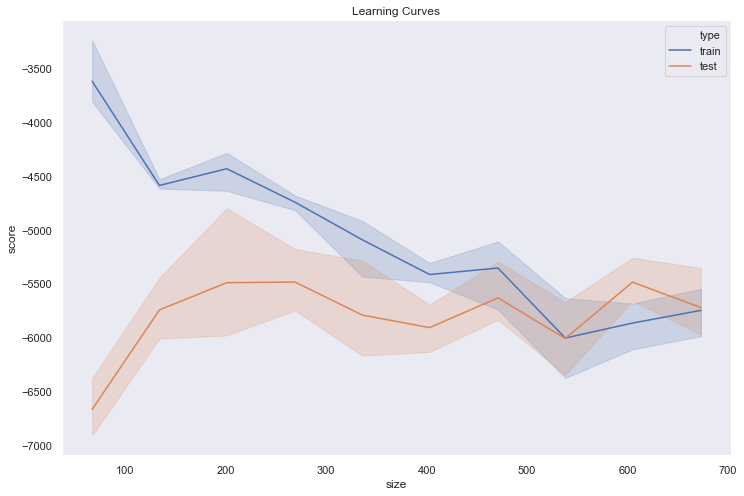

In [129]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [130]:
cv_res = get_cv_res(pipeline,
                    X_train[selected_features],
                    y_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'],
                    cv=cv)

In [131]:
print_cv_res(cv_res)

Mean fit_time, 0.09
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -5915.31
Mean test_r2, 0.74
Mean test_explained_variance, 0.75
Mean test_max_error, -45587.12


## Display Predicted VS Actual

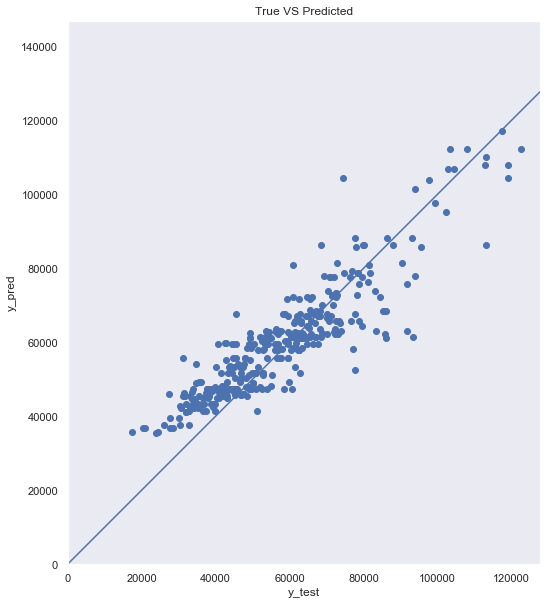

In [132]:
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-5e7, 5e7], [-5e7, 5e7])
plt.title('True VS Predicted')
plt.show()

## Display Error Spread

In [133]:
to_plot = X_test.join(y_pred).join(y_test)
to_plot['pred_diff'] = to_plot['predicted'] - to_plot[target]

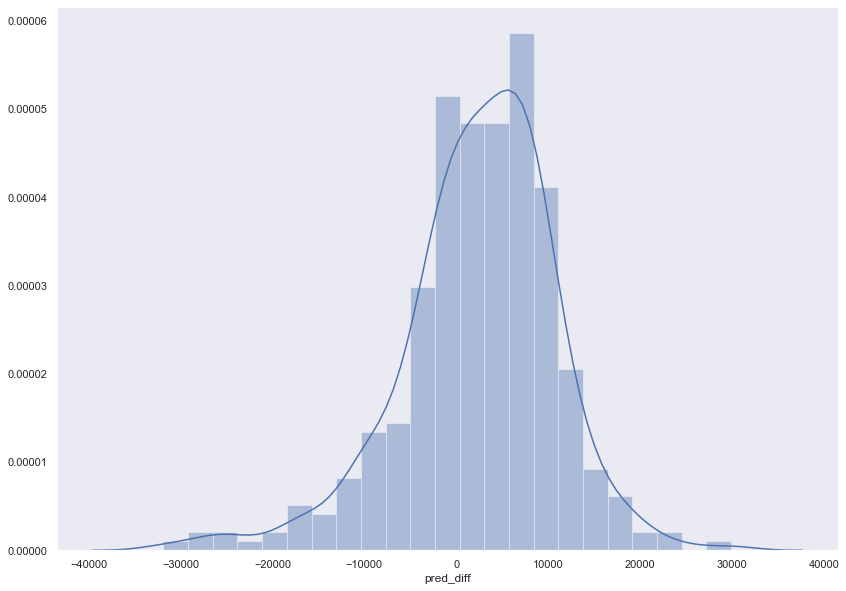

In [134]:
sns.distplot(to_plot.pred_diff)

### Top Overvalued

In [135]:
to_plot[(to_plot.pred_diff > 5e3) | (to_plot.pred_diff < 5e3)].sort_values('pred_diff', ascending=False).head()

,,primary_size,time_s,floor,num_bedrooms,construction_year,med_price_apartment,med_price_house,mean_post_code_rating,post_code_place_count,bank,cafe,car_dealer,car_repair,clothing_store,dentist,doctor,electrician,electronics_store,establishment,finance,florist,food,furniture_store,gas_station,general_contractor,grocery_or_supermarket,gym,hair_care,hardware_store,health,home_goods_store,lodging,meal_delivery,meal_takeaway,pharmacy,place_of_worship,plumber,point_of_interest,post_office,real_estate_agency,restaurant,school,storage,store,supermarket,transit_station,comb_property_type_house,ownership_type_Andel,ownership_type_Eier (Selveier),new_building_True,exclusive_True,predicted,price_per_sq_m,pred_diff
ad_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
149861022,4487,82.0,1544.0,2.0,2.0,2009.0,113015.5,93957.0,4.542857,7.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,10.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0,0,1,0,0,104463.275862,74542.0,29921.275862
115787431,876,77.0,3004.0,5.0,2.0,2019.0,40442.0,42543.0,4.492308,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,13.0,0.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,0,1,0,1,0,55717.313953,31169.0,24548.313953
149615913,4342,72.0,1763.0,6.0,3.0,1969.0,72596.0,46875.5,3.285714,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,1,67528.592920,45493.0,22035.592920
149792880,4412,56.0,1734.0,2.0,2.0,1960.0,60793.0,103372.0,3.820000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,0.0,0,1,0,0,0,80970.606061,60793.0,20177.606061
69757913,10,106.0,2771.0,2.0,2.0,2019.0,47896.0,33268.0,4.090000,10.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,1.0,1.0,4.0,1.0,0.0,0,0,1,1,0,54187.319149,34709.0,19478.319149


### Top Undervalued

In [136]:
to_plot[(to_plot.pred_diff > 5e3) | (to_plot.pred_diff < 5e3)].sort_values('pred_diff', ascending=False).tail()

,,primary_size,time_s,floor,num_bedrooms,construction_year,med_price_apartment,med_price_house,mean_post_code_rating,post_code_place_count,bank,cafe,car_dealer,car_repair,clothing_store,dentist,doctor,electrician,electronics_store,establishment,finance,florist,food,furniture_store,gas_station,general_contractor,grocery_or_supermarket,gym,hair_care,hardware_store,health,home_goods_store,lodging,meal_delivery,meal_takeaway,pharmacy,place_of_worship,plumber,point_of_interest,post_office,real_estate_agency,restaurant,school,storage,store,supermarket,transit_station,comb_property_type_house,ownership_type_Andel,ownership_type_Eier (Selveier),new_building_True,exclusive_True,predicted,price_per_sq_m,pred_diff
ad_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
150369383,4787,93.0,2456.0,3.0,3.0,2016.0,72224.0,46466.0,4.380000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,1,0,0,61123.015936,86084.0,-24960.984064
150596184,4908,119.0,5065.0,2.0,2.0,1917.0,56876.0,67407.0,4.480000,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,1,0,0,52571.098765,77648.0,-25076.901235
146511195,3527,63.0,1822.0,6.0,2.0,2019.0,81275.0,67390.0,4.333333,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,15.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,15.0,1.0,0.0,0.0,2.0,1.0,6.0,2.0,0.0,0,1,0,1,0,86202.335766,113166.0,-26963.664234
123497316,1378,139.0,3521.0,7.0,3.0,2019.0,63647.5,45510.0,4.600000,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0,1,1,0,63068.650407,91727.0,-28658.349593
146449947,3447,150.0,2126.0,2.0,4.0,2019.0,67460.0,44562.0,4.216667,6.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0,3.0,16.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,16.0,0.0,0.0,1.0,0.0,0.0,13.0,0.0,0.0,0,0,1,1,0,61408.189055,93267.0,-31858.810945


# Display Feature Importances

In [137]:
feature_importances = pd.Series(pipeline.named_steps['estimator'].feature_importances_, index=selected_features).sort_values(ascending=True)

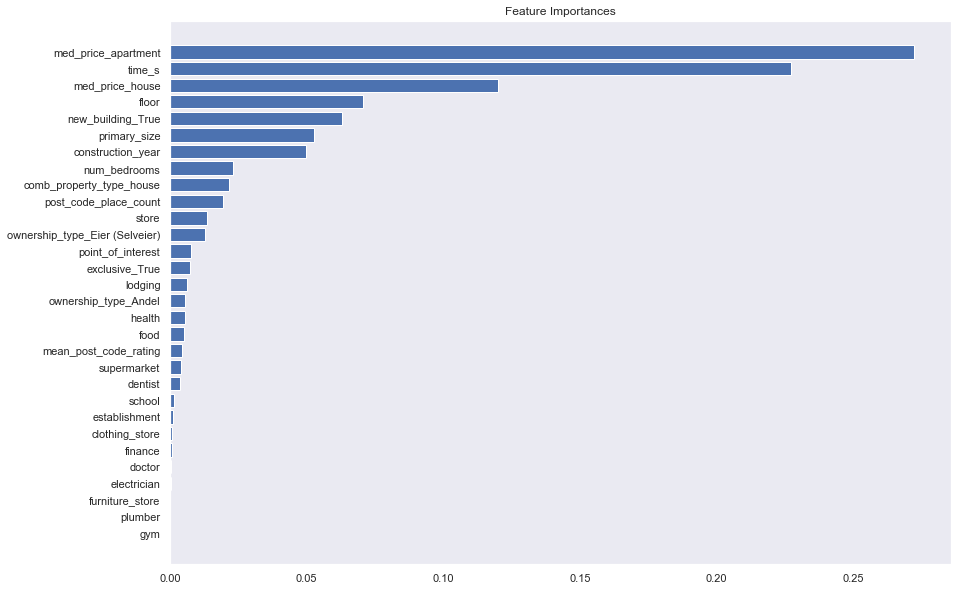

In [138]:
top_n = 30
to_plot = feature_importances[-top_n:]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With NLP

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

In [140]:
stop_words = ['av', 'og', 'til', 'over', 'fra', 'om',
              'den', 'det', 'denne', 'dette', 'ved',
              'in', 'inn', 'en', 'opp', 'ikke', 'oss',
              'for', 'du', 'fortsatt', 'flere', 'eller',
              'hele', 'her', 'men', 'kan', 'meget',
              'ingen', 'inntil', 'mer']

real_estate_terms = ['solgt', 'informasjon', 'bygget',
                     'leiligheter', 'salg', 'solgte', 'bell']

other_terms = ['inkl', 'nn', 'dok', 'str', 'avg', 'yt',
               'kl', 'kj', 'hj', 'schl', 'nyg']

stop_words = stop_words + real_estate_terms + other_terms

In [141]:
count_vectorizer = CountVectorizer(ngram_range=(1, 1),
                                   token_pattern = r'[A-z\-]{3,}',
                                   strip_accents=None,
                                   lowercase=True,
                                   stop_words=stop_words,
                                   # vocabulary=
                                   min_df=1,
                                   max_features = 5000)

In [142]:
vectorized_full_desc = count_vectorizer.fit_transform(data_sample_from_new_buildings[data_sample_from_new_buildings.index.isin(model_data.index)].short_description)

In [143]:
tfidf_transformer = TfidfTransformer()

In [144]:
tfidf = tfidf_transformer.fit_transform(vectorized_full_desc)

In [145]:
tfidf

<1204x1222 sparse matrix of type '<class 'numpy.float64'>'
	with 12158 stored elements in Compressed Sparse Row format>

In [146]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(tfidf,
                                                                        y,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [147]:
estimator.fit(X_text_train, y_text_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [148]:
y_text_pred = estimator.predict(X_text_test)

# Draw Learning Curves

In [149]:
learning_curve_res = get_learning_curves(estimator,
                                         X_text_train,
                                         y_text_train,
                                         score='neg_median_absolute_error')

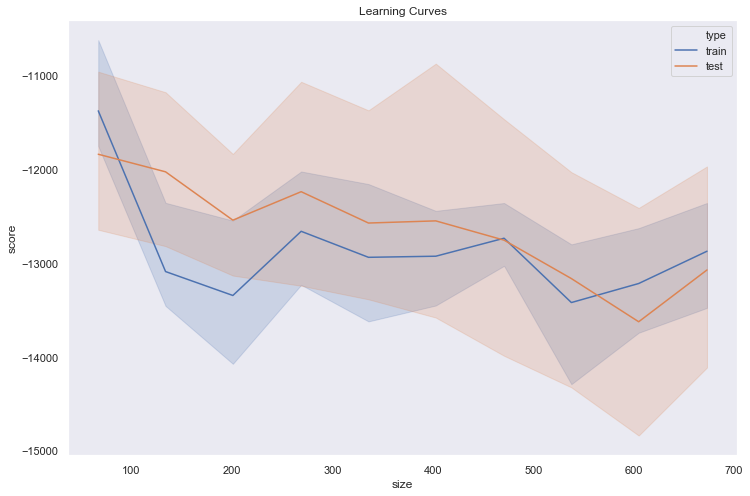

In [150]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [151]:
cv_res = get_cv_res(estimator,
                    X_text_train,
                    y_text_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [152]:
print_cv_res(cv_res)

Mean fit_time, 0.05
Mean score_time, 0.01
Mean test_neg_median_absolute_error, -13651.59
Mean test_r2, 0.06
Mean test_explained_variance, 0.16
Mean test_max_error, -58728.65


In [153]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()))

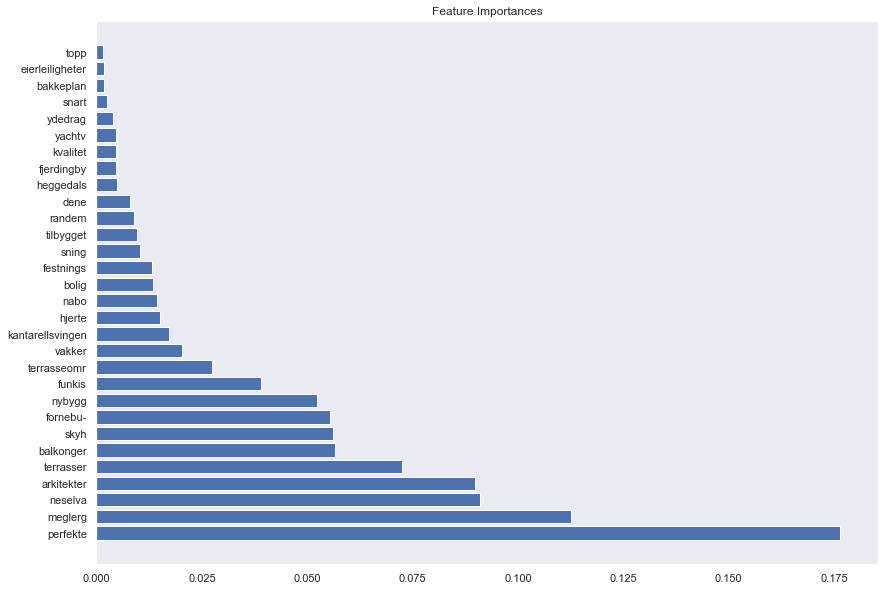

In [154]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

# Predict Price With All Features

In [155]:
# all_features = scipy.sparse.hstack([vectorized_full_desc, X_sparse])
all_features = scipy.sparse.hstack([tfidf, X_sparse])

In [156]:
all_features

<1204x1273 sparse matrix of type '<class 'numpy.float64'>'
	with 37881 stored elements in COOrdinate format>

In [157]:
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(all_features,
                                                                        y,
                                                                        test_size=test_size,
                                                                        random_state=random_seed)

In [158]:
estimator.fit(X_full_train, y_full_train)

AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
                  n_estimators=50, random_state=42)

In [159]:
y_pred = estimator.predict(X_full_test)

# Draw Learning Curves

In [160]:
learning_curve_res = get_learning_curves(estimator,
                                         X_full_train,
                                         y_full_train,
                                         score='neg_median_absolute_error')

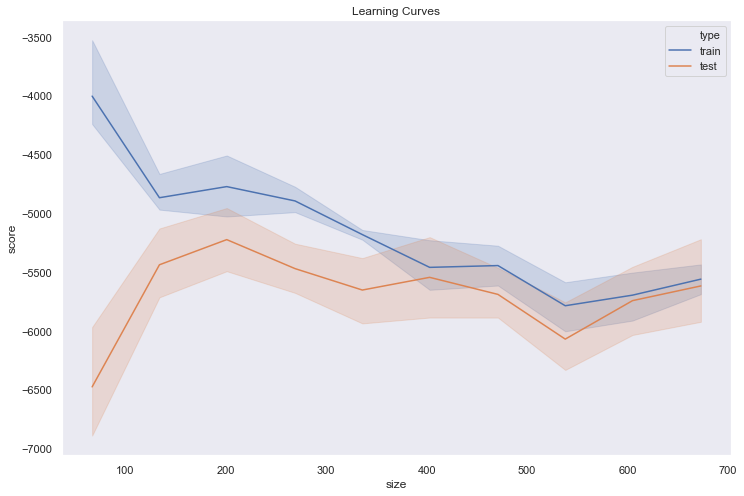

In [161]:
fig = plt.figure(figsize = (12, 8))
plt.title('Learning Curves')
sns.lineplot(x='size', y='score', hue='type', data=learning_curve_res)
plt.show()

# Display Cross-Validation Results

In [162]:
cv_res = get_cv_res(estimator,
                    X_full_train,
                    y_full_train,
                    score=['neg_median_absolute_error',
                           'r2',
                           'explained_variance',
                           'max_error'])

In [163]:
print_cv_res(cv_res)

Mean fit_time, 0.15
Mean score_time, 0.02
Mean test_neg_median_absolute_error, -5895.14
Mean test_r2, 0.76
Mean test_explained_variance, 0.77
Mean test_max_error, -40720.19


# Display Feature Importances

In [164]:
feature_importances = pd.Series(estimator.feature_importances_, index=list(count_vectorizer.vocabulary_.keys()) + list(x_cols)).sort_values(ascending=True)

In [165]:
feature_importances.sort_values(ascending=False)[:30]

med_price_apartment         0.293979
time_s                      0.197389
med_price_house             0.115283
construction_year           0.084247
primary_size                0.067203
floor                       0.055613
comb_property_type_house    0.048282
post_code_place_count       0.029483
blant                       0.021743
new_building_True           0.014535
health                      0.009806
point_of_interest           0.007751
meglerg                     0.006578
establishment               0.005435
sning                       0.004049
kantarellsvingen            0.003782
num_bedrooms                0.003544
neselva                     0.003378
topp                        0.003193
mean_post_code_rating       0.002896
store                       0.002207
kvm-                        0.002130
lodging                     0.001941
furniture_store             0.001816
snart                       0.001579
clothing_store              0.001425
husebyhagen                 0.001370
d

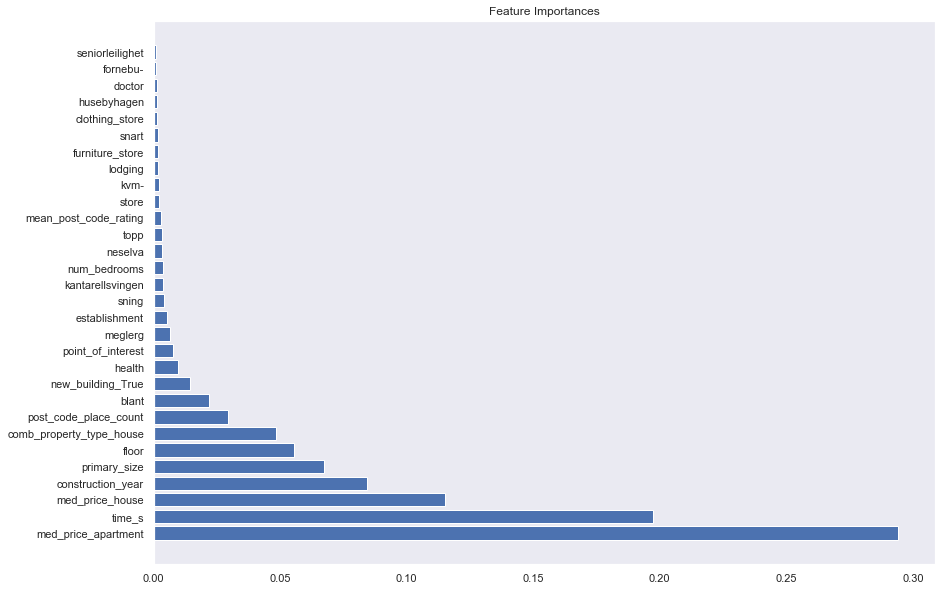

In [166]:
to_plot = feature_importances.sort_values(ascending=False)[:30]
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Feature Importances')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

In [167]:
vocab = pd.Series(list(count_vectorizer.vocabulary_.values()), index=count_vectorizer.vocabulary_.keys())

In [168]:
vocab.sort_values(ascending=False)[:10]

ytterkant    1221
ype          1220
yes          1219
yenenga      1218
yen          1217
yden         1216
ydedrag      1215
yde          1214
yachtv       1213
wessel       1212
dtype: int64

# TODO
* Draw learning curves on multiple metrics
* Limit the number of place types on the neighborhood data
* Save CSV data to BQ database
* Implement better tokenizer and pass the results to the TFIDF
* Produce statistics for all types of models
* Select final model
* Tune up the final model
* Deploy model to cloud